In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tqdm as tq
from numba import jit

In [2]:
def plot_img3d(img2D_array):
    # 3D plot
    # create the x and y coordinate arrays (here we just use pixel indices)
    xx, yy = np.mgrid[0:img2D_array.shape[0], 0:img2D_array.shape[1]]
    # create the figure
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx, yy, img2D_array, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
    # show it
    plt.show()

/var/folders/91/hqcww5cd6j79klvx9v2cpwbh0000gn/T/ipykernel_2086/1422544936.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


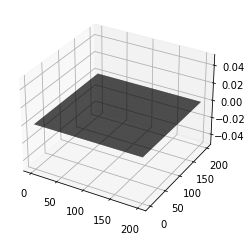

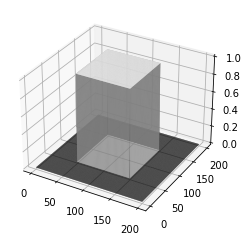

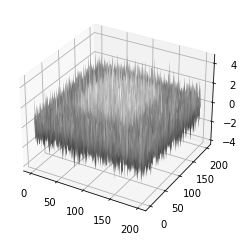

In [3]:
u0 = np.zeros((201, 201))
plot_img3d(u0)
u0[50:150, 50:150] = 1
plot_img3d(u0)
u0 = u0 + np.random.normal(size=(201, 201), scale=1)
#u0 = (u0-np.min(u0))/(np.max(u0)-np.min(u0))
plot_img3d(u0)

In [4]:
def m(a, b):
    return (np.sign(a)+np.sign(b)) * np.minimum(np.abs(a), np.abs(b))/2

In [5]:
def TV_f(ux_f, uy_f):
    return np.sum(np.sqrt(ux_f**2 + uy_f**2))

def forward_x_derivative(u):
    h, w = u.shape
    u_shifted_left = np.zeros((h, w))
    
    u_shifted_left[:, 0:w-1] = u[:, 1:w]
    u_shifted_left[:, w-1] = u[:, w-1]
    
    return u_shifted_left - u
    
def forward_y_derivative(u):
    h, w = u.shape
    u_shifted_down = np.zeros((h, w))
    
    u_shifted_down[1:h, :] = u[0:h-1, :]
    u_shifted_down[0,:] = u[0, :]
    
    return u_shifted_down - u

def backward_x_derivative(u):
    h, w = u.shape
    u_shifted_right = np.zeros((h, w))
    
    u_shifted_right[:, 1:w] = u[:, 0:w-1]
    u_shifted_right[:, 0] = u[:, 0]
    
    return u - u_shifted_right

def backward_y_derivative(u):
    h, w = u.shape
    u_shifted_up = np.zeros((h, w))
     
    u_shifted_up[0:h-1] = u[1:h]
    u_shifted_up[h-1] = u[h-1]
    
    return u - u_shifted_up

In [6]:
def denoise_image(og_image, num_iters, del_t = 0.125, eps = 1e-5):
    sigma = 1
    N = og_image.shape[0]
    
    u0x_f = forward_x_derivative(og_image)
    u0y_f = forward_y_derivative(og_image)

    # denoise
    u = og_image
    for n in range(num_iters):
        # Boundary conditions
        u[:, 0] = u[:, 1] 
        u[:, N-1] = u[:, N-2] 
        u[0, :]  = u[1, :] 
        u[N-1, :]  = u[N-2, :] 

        # Image derivatives
        ux_f = forward_x_derivative(u)
        uy_f = forward_y_derivative(u)
        ux_b = backward_x_derivative(u)
        uy_b = backward_y_derivative(u)

        # Derivative of TV w.r.t. ux and uy, respectively.
        TV_ux_f = ux_f/np.sqrt(eps + ux_f**2 + m(uy_f, uy_b)**2)
        TV_uy_f = uy_f/np.sqrt(eps + uy_f**2 + m(ux_f, ux_b)**2)

        # Derivative of derivative of TV w.r.t. ux w.r.t. x
        TV_ux_f_x_b = backward_x_derivative(TV_ux_f)
        # Derivative of derivative of TV w.r.t. uy w.r.t. y
        TV_uy_f_y_b = backward_y_derivative(TV_uy_f)
        
        # Get lambda
        lamb = 0.1
        
        # Update u
        u = u + del_t*(TV_ux_f_x_b + TV_uy_f_y_b - lamb*(u-og_image))
        
        # Normalize u
        u = (u-np.min(u))/(np.max(u)-np.min(u))
        
        #print("n:", n, ",TV:", TV_f(ux_f, uy_f))
        
    print("og image")
    plt.imshow(og_image, cmap='gray')
    plt.show()

        
    print("u")
    plt.imshow(u, cmap='gray')
    plt.show()


og image


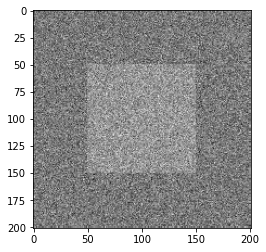

u


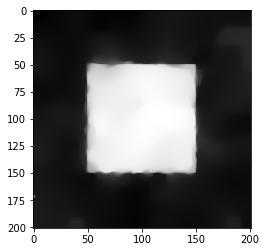

In [7]:
denoise_image(u0, 5000, del_t = 0.0001, eps = 1e-5)

In [8]:
# Plot surface and see what is happening.
# Don't read in image.